In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def plot_subpolar_gyre_timeseries(
    netcdf_file,
    variable_name='tos',
    lat_bounds=(45, 65),
    lon_bounds=(-60, 0),
    title="Subpolar Gyre Mean SST (°C)",
    output_file=None
):
    """
    Compute and plot the yearly mean of a variable (e.g. tos) over the Subpolar Gyre region.
    """

    # Load dataset
    ds = xr.open_dataset(netcdf_file, use_cftime=True)
    data = ds[variable_name]

    # Extract lat/lon
    lats = ds['latitude']
    lons = ds['longitude']

    # Convert longitudes from 0–360 to -180–180 if needed
    if lons.max() > 180:
        lons = xr.where(lons > 180, lons - 360, lons)

    # Create mask for region
    region_mask = ((lats >= lat_bounds[0]) & (lats <= lat_bounds[1]) &
                   (lons >= lon_bounds[0]) & (lons <= lon_bounds[1]))

    # Mask data to region
    tos_region = data.where(region_mask)

    # Compute area-weighted mean for each time step
    weights = np.cos(np.deg2rad(lats))
    tos_weighted = tos_region.weighted(weights)

    regional_mean = tos_weighted.mean(dim=("j", "i"))

    # Compute yearly mean
    tos_yearly = regional_mean.resample(time="Y").mean()

    # Plot time series
    plt.figure(figsize=(10, 5))
    tos_yearly.plot(marker='o', color='steelblue')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("SST (°C)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Save if requested
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as: {output_file}")

    ds.close()
    plt.show()

    return tos_yearly




/tmp/ipykernel_2389649/1975622886.py:18: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(netcdf_file, use_cftime=True)
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Plot saved as: subpolar_gyre_sst_timeseries.png


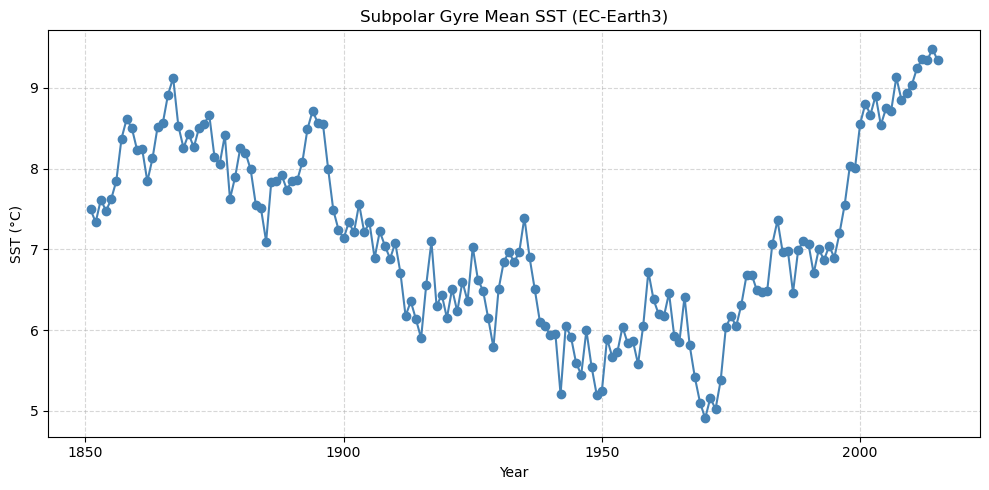

In [2]:
tos_yearly = plot_subpolar_gyre_timeseries(
    netcdf_file="/data/projects/nckf/cmip6/historical/EC-Earth3/r1i1p1f1/Omon/tos/tos_Omon_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc",
    variable_name="tos",
    lat_bounds=(45, 65),
    lon_bounds=(-60, 0),
    title="Subpolar Gyre Mean SST (EC-Earth3)",
    output_file="subpolar_gyre_sst_timeseries.png"
)


In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def plot_subpolar_gyre_timeseries(
    netcdf_file,
    variable_name,
    lat_bounds=(45, 65),
    lon_bounds=(-60, 0),
    title=None,
    output_file=None
):
    """
    Compute and plot yearly mean of a variable over a region (e.g., Subpolar Gyre).
    
    Parameters
    ----------
    netcdf_file : str
        Path to NetCDF file
    variable_name : str
        Name of variable ('tos' or 'sos')
    lat_bounds : tuple
        Latitude bounds of the region (min, max)
    lon_bounds : tuple
        Longitude bounds of the region (min, max, can be negative)
    title : str, optional
        Plot title
    output_file : str, optional
        Path to save plot
    
    Returns
    -------
    da_yearly : xarray.DataArray
        Yearly mean time series
    """
    # Load dataset
    ds = xr.open_dataset(netcdf_file)
    da = ds[variable_name]
    lats = ds['latitude']
    lons = ds['longitude']

    # Identify spatial dimensions automatically
    spatial_dims = [d for d in da.dims if d != "time"]
    lat_name = "latitude" if "latitude" in ds else "lat"
    lon_name = "longitude" if "longitude" in ds else "lon"

    lats = ds[lat_name]
    lons = ds[lon_name]

    # Convert longitudes to 0–360 if necessary
    lons_360 = xr.where(lons < 0, lons + 360, lons)
    lon_min = lon_bounds[0] % 360
    lon_max = lon_bounds[1] % 360

    # Handle wrap-around
    if lon_min < lon_max:
        lon_mask = (lons_360 >= lon_min) & (lons_360 <= lon_max)
    else:
        lon_mask = (lons_360 >= lon_min) | (lons_360 <= lon_max)

    # Mask region
    region_mask = (lats >= lat_bounds[0]) & (lats <= lat_bounds[1]) & lon_mask
    da_region = da.where(region_mask)

    # Check for missing values in weights
    weights = np.cos(np.deg2rad(lats))
    weights = xr.where(np.isnan(weights), 0, weights)

    # Compute weighted spatial mean (over y and x)
    spatial_dims = [d for d in da_region.dims if d not in ['time']]
    da_region_weighted = da_region.weighted(weights)
    regional_mean = da_region_weighted.mean(dim=spatial_dims)

    # Compute yearly mean
    da_yearly = regional_mean.resample(time='Y').mean()

    # Plot
    plt.figure(figsize=(10, 5))
    da_yearly.plot(marker='o', color='steelblue')
    if title is None:
        title = f"{variable_name.upper()} - Subpolar Gyre Yearly Mean"
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(f"{variable_name.upper()} ({'°C' if variable_name=='tos' else 'PSU'})")
    plt.grid(True)

    if output_file is not None:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    plt.show()

    ds.close()
    return da_yearly



/dmidata/users/frekle/miniforge3/envs/aimoc_env/lib/python3.11/site-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Plot saved to subpolar_gyre_sst_timeseries.png


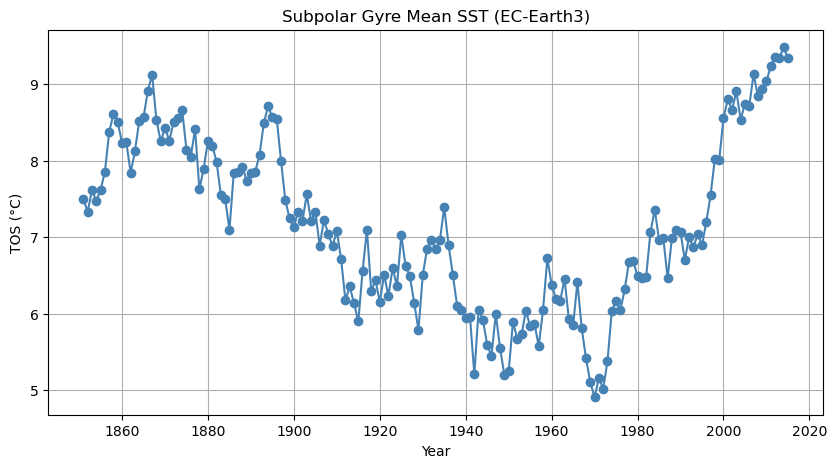

/dmidata/users/frekle/miniforge3/envs/aimoc_env/lib/python3.11/site-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Plot saved to subpolar_gyre_sos_timeseries.png


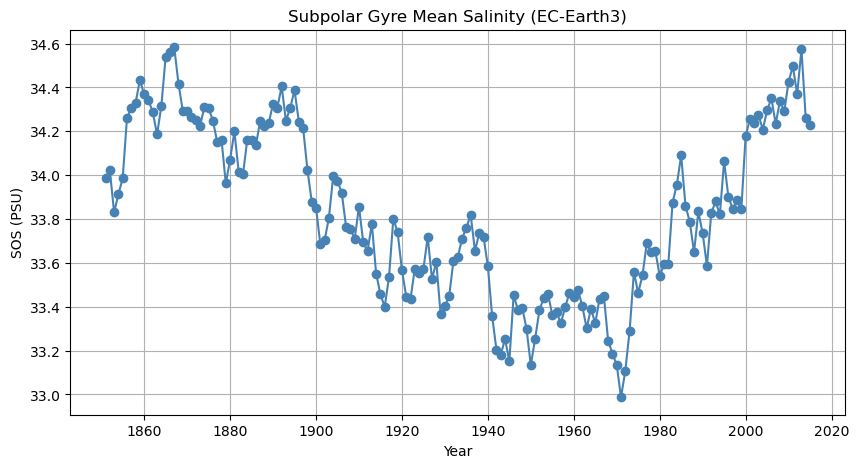

In [17]:
# For temperature (tos)
tos_yearly = plot_subpolar_gyre_timeseries(
    netcdf_file="/data/projects/nckf/cmip6/historical/EC-Earth3/r1i1p1f1/Omon/tos/tos_Omon_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc",
    variable_name="tos",
    lat_bounds=(45, 65),
    lon_bounds=(-60, 0),
    title="Subpolar Gyre Mean SST (EC-Earth3)",
    output_file="subpolar_gyre_sst_timeseries.png"
)

# For salinity (sos)
sos_yearly = plot_subpolar_gyre_timeseries(
    netcdf_file="/data/projects/nckf/cmip6/historical/EC-Earth3/r1i1p1f1/Omon/sos/sos_Omon_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc",
    variable_name="sos",
    lat_bounds=(45, 65),
    lon_bounds=(-60, 0),
    title="Subpolar Gyre Mean Salinity (EC-Earth3)",
    output_file="subpolar_gyre_sos_timeseries.png"
)



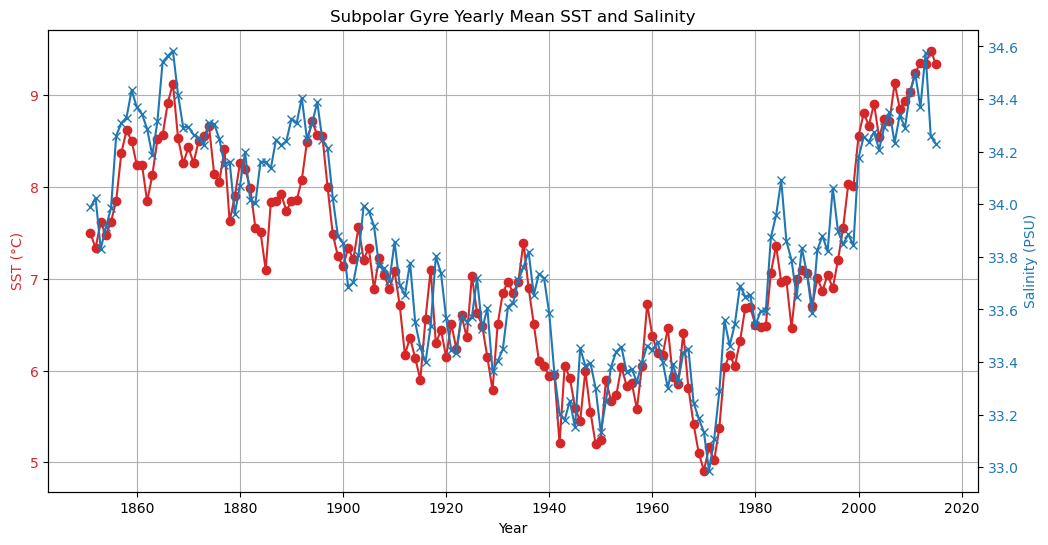

In [18]:
import matplotlib.pyplot as plt

# Make sure tos_yearly and sos_yearly already exist
fig, ax1 = plt.subplots(figsize=(12, 6))

# SST
color_sst = "tab:red"
ax1.plot(tos_yearly.time, tos_yearly, color=color_sst, marker="o", label="SST")
ax1.set_xlabel("Year")
ax1.set_ylabel("SST (°C)", color=color_sst)
ax1.tick_params(axis="y", labelcolor=color_sst)

# Salinity on a secondary y-axis
ax2 = ax1.twinx()
color_sos = "tab:blue"
ax2.plot(sos_yearly.time, sos_yearly, color=color_sos, marker="x", label="Salinity")
ax2.set_ylabel("Salinity (PSU)", color=color_sos)
ax2.tick_params(axis="y", labelcolor=color_sos)

# Title and grid
plt.title("Subpolar Gyre Yearly Mean SST and Salinity")
ax1.grid(True)

plt.show()
